## Defensive Distillation for LFW

In [2]:
import numpy as np
import keras
from keras import Model
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from keras.layers import Input
from keras.layers import Conv2D, GlobalAvgPool2D
from keras.layers import Dropout, Activation
class LFW:
  def __init__(self):
    test_split = 0.2
    lfw_people = fetch_lfw_people(min_faces_per_person=35, color=True, resize=1.0,
                              slice_=(slice(48, 202), slice(48, 202)))

    self.X = lfw_people.images
    self.y = lfw_people.target
    target_names = lfw_people.target_names
    self.n_classes = target_names.shape[0]
    # train/test split
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_split, 
                                                        stratify=self.y, random_state=42)

    # oversampling each class to contain at least 256 examples
    sampling_targets = np.maximum([256] * self.n_classes, np.bincount(self.y_train))
    ratio_dict = dict(zip(range(self.n_classes), sampling_targets))
    ros = RandomOverSampler(ratio=ratio_dict, random_state=42)

    self.X_train_shape = self.X_train.shape
    self.X_train = np.reshape(self.X_train, (self.X_train_shape[0], -1))
    self.X_train, self.y_train = ros.fit_sample(self.X_train, self.y_train)
    self.X_train = np.reshape(self.X_train, (len(self.X_train),) + self.X_train_shape[1:])

    # one-hot encoding of labels
    self.y_train = keras.utils.to_categorical(self.y_train, self.n_classes)
    self.y_test = keras.utils.to_categorical(self.y_test, self.n_classes)
    
    

Using TensorFlow backend.


In [0]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.optimizers import SGD

def train_lfw(data, num_epochs=100, batch_size=256, train_temp=1, init=None):
  datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.05,
      zoom_range=0.1)
  test_split = 0.2
  base_lr = 0.001
  input = Input(shape=data.X.shape[1:])                                  # 154x154x3
  x = Conv2D(12, (3, 3), padding='same', activation='relu')(input)  # 154x154x12
  x = Conv2D(12, (2, 2), strides=(2, 2), activation='relu')(x)      # 77x77x12
  x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)      # 77x77x16
  x = Conv2D(16, (2, 2), strides=(2, 2), activation='relu')(x)      # 38x38x16
  x = Conv2D(24, (3, 3), padding='same', activation='relu')(x)      # 38x38x24
  x = Conv2D(24, (2, 2), strides=(2, 2), activation='relu')(x)      # 19x19x24
  x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)      # 19x19x32
  x = Conv2D(32, (2, 2), strides=(2, 2), activation='relu')(x)      # 9x9x32
  x = Conv2D(48, (3, 3), padding='same', activation='relu')(x)      # 9x9x48
  x = Conv2D(48, (2, 2), strides=(2, 2), activation='relu')(x)      # 4x4x48
  x = Dropout(0.5)(x)                                               # 4x4x48
  x = Conv2D(data.n_classes, (1, 1))(x)                                  # 4x4x62
  x = GlobalAvgPool2D()(x)                                          # 62
  output = Activation('softmax')(x) 
  model = Model(inputs=input, outputs=output)
  
  def fn(correct, predicted):
#         print(predicted)
        return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                       logits=predicted/train_temp)
  sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss=fn,
                optimizer= keras.optimizers.Nadam(lr=base_lr),
                metrics=['accuracy'])
  history = model.fit_generator(datagen.flow(data.X_train, data.y_train, batch_size=batch_size),
                    steps_per_epoch=len(data.X_train) / batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=(data.X_test, data.y_test))
  
#   model.load_weights('weights100epochs.h5')
  return model


In [4]:
lfw_model = train_lfw(LFW())

KeyboardInterrupt: ignored

In [0]:
def train_distillation_lfw(data, num_epochs=50, batch_size=128, train_temp=1):
    """
    Train a network using defensive distillation.
    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
#     if not os.path.exists(file_name+"_init"):
#         # Train for one epoch to get a good starting point.
#         train(data, 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train_lfw(data, num_epochs, batch_size, train_temp)

    # evaluate the labels at temperature t
    predicted = teacher.predict(data.X_train)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        print(y)
        data.y_train = y

    # train the student model at temperature t
    student = train_lfw(data, num_epochs, batch_size, train_temp)

    # and finally we predict at temperature 1
    predicted = student.predict(data.X_train)

    print(predicted)
    
    return student
    
# if not os.path.isdir('models'):
#     os.makedirs('models')

In [7]:
lfw_distillation_model = train_distillation_lfw(LFW(), train_temp=5)

Epoch 1/50
50/49 [==============================] - 29s 578ms/step - loss: 3.1755 - acc: 0.0575 - val_loss: 3.1357 - val_acc: 0.2579
Epoch 2/50
50/49 [==============================] - 27s 548ms/step - loss: 3.1738 - acc: 0.0669 - val_loss: 3.1357 - val_acc: 0.2579
Epoch 3/50
50/49 [==============================] - 28s 560ms/step - loss: 3.1738 - acc: 0.0673 - val_loss: 3.1357 - val_acc: 0.2579
Epoch 4/50
50/49 [==============================] - 28s 566ms/step - loss: 3.1737 - acc: 0.0676 - val_loss: 3.1357 - val_acc: 0.2579
Epoch 5/50
46/49 [==========================>...] - ETA: 1s - loss: 3.1738 - acc: 0.0671

KeyboardInterrupt: ignored

## Defensive Distillation for MNIST and CIFAR

In [0]:

import tensorflow as tf
import numpy as np
import os
import pickle
import gzip
import pickle
import urllib.request

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model

def load_batch(fpath, label_key='labels'):
    f = open(fpath, 'rb')
    d = pickle.load(f, encoding="bytes")
    for k, v in d.items():
        del(d[k])
        d[k.decode("utf8")] = v
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    final = np.zeros((data.shape[0], 32, 32, 3),dtype=np.float32)
    final[:,:,:,0] = data[:,0,:,:]
    final[:,:,:,1] = data[:,1,:,:]
    final[:,:,:,2] = data[:,2,:,:]

    final /= 255
    final -= .5
    labels2 = np.zeros((len(labels), 10))
    labels2[np.arange(len(labels2)), labels] = 1

    return final, labels

def load_batch(fpath):
    f = open(fpath,"rb").read()
    size = 32*32*3+1
    labels = []
    images = []
    for i in range(10000):
        arr = np.fromstring(f[i*size:(i+1)*size],dtype=np.uint8)
        lab = np.identity(10)[arr[0]]
        img = arr[1:].reshape((3,32,32)).transpose((1,2,0))

        labels.append(lab)
        images.append((img/255)-.5)
    return np.array(images),np.array(labels)
    

class CIFAR:
    def __init__(self):
        train_data = []
        train_labels = []
        
        if not os.path.exists("cifar-10-batches-bin"):
            urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz",
                                       "cifar-data.tar.gz")
            os.popen("tar -xzf cifar-data.tar.gz").read()
            

        for i in range(5):
            r,s = load_batch("cifar-10-batches-bin/data_batch_"+str(i+1)+".bin")
            train_data.extend(r)
            train_labels.extend(s)
            
        train_data = np.array(train_data,dtype=np.float32)
        train_labels = np.array(train_labels)
        
        self.test_data, self.test_labels = load_batch("cifar-10-batches-bin/test_batch.bin")
        
        VALIDATION_SIZE = 5000
        
        self.validation_data = train_data[:VALIDATION_SIZE, :, :, :]
        self.validation_labels = train_labels[:VALIDATION_SIZE]
        self.train_data = train_data[VALIDATION_SIZE:, :, :, :]
        self.train_labels = train_labels[VALIDATION_SIZE:]



In [0]:
import tensorflow as tf
import numpy as np
import os
import pickle
import gzip
import urllib.request

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model

def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(num_images*28*28)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data / 255) - 0.5
        data = data.reshape(num_images, 28, 28, 1)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8)
    return (np.arange(10) == labels[:, None]).astype(np.float32)

class MNIST:
    def __init__(self):
        if not os.path.exists("data"):
            os.mkdir("data")
            files = ["train-images-idx3-ubyte.gz",
                     "t10k-images-idx3-ubyte.gz",
                     "train-labels-idx1-ubyte.gz",
                     "t10k-labels-idx1-ubyte.gz"]
            for name in files:

                urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/' + name, "data/"+name)

        train_data = extract_data("data/train-images-idx3-ubyte.gz", 60000)
        train_labels = extract_labels("data/train-labels-idx1-ubyte.gz", 60000)
        self.test_data = extract_data("data/t10k-images-idx3-ubyte.gz", 10000)
        self.test_labels = extract_labels("data/t10k-labels-idx1-ubyte.gz", 10000)
        
        VALIDATION_SIZE = 5000
        
        self.validation_data = train_data[:VALIDATION_SIZE, :, :, :]
        self.validation_labels = train_labels[:VALIDATION_SIZE]
        self.train_data = train_data[VALIDATION_SIZE:, :, :, :]
        self.train_labels = train_labels[VALIDATION_SIZE:]



In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

import tensorflow as tf
# from setup_mnist import MNIST
# from setup_cifar import CIFAR
import os

def train(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (3, 3),
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(params[1], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[2], (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(params[3], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(params[4]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params[5]))
    model.add(Activation('relu'))
    model.add(Dense(10))
    
    if init != None:
        model.load_weights(init)

    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                       logits=predicted/train_temp)

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    

    if file_name != None:
        model.save(file_name)

    return model

def train_distillation(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1):
    """
    Train a network using defensive distillation.
    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
    if not os.path.exists(file_name+"_init"):
        # Train for one epoch to get a good starting point.
        train(data, file_name+"_init", params, 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train(data, file_name+"_teacher", params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # evaluate the labels at temperature t
    predicted = teacher.predict(data.train_data)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        print(y)
        data.train_labels = y

    # train the student model at temperature t
    student = train(data, file_name, params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # and finally we predict at temperature 1
    predicted = student.predict(data.train_data)

#     print(predicted)
    return student
    
if not os.path.isdir('models'):
    os.makedirs('models')

# cifar_model = train(CIFAR(), "models/cifar", [64, 64, 128, 128, 256, 256], num_epochs=50)
# mnist_model = train(MNIST(), "models/mnist", [32, 32, 64, 64, 200, 200], num_epochs=12)

# train_distillation(MNIST(), "models/mnist-distilled-100", [32, 32, 64, 64, 200, 200],
#                    num_epochs=50, train_temp=100)
# train_distillation(CIFAR(), "models/cifar-distilled-100", [64, 64, 128, 128, 256, 256],
#                    num_epochs=50, train_temp=100)

In [5]:
mnist_model = train(MNIST(), "models/mnist", [32, 32, 64, 64, 200, 200], num_epochs=12)

(55000, 28, 28, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/12
55000/55000 [==============================] - 9s 158us/step - loss: 0.7027 - acc: 0.7663 - val_loss: 0.0930 - val_acc: 0.9716
Epoch 2/12
55000/55000 [==============================] - 3s 58us/step - loss: 0.1261 - acc: 0.9618 - val_loss: 0.0626 - val_acc: 0.9816
Epoch 3/12
55000/55000 [==============================] - 3s 58us/step - loss: 0.0861 - acc: 0.9742 - val_loss: 0.0492 - val_acc: 0.9878
Epoch 4/12
55000/55000 [==============================] - 3s 58us/step - loss: 0.0672 - acc: 0.9798 - val_loss: 0.0473 - val_acc: 0.9866
Epoch 5/12
55000/55000 [==============================] - 3s 58us/step - loss: 0.0573 - acc: 0.9828 - val_loss: 0.0450 - val_acc: 0.9874
Epoch 6/12
55000/55000 [==============================] - 3s 58us/step - loss: 0.0490 - acc: 0.9847 - val_loss: 0.0411 - val_acc: 0.9900
Epoch 7/12
55000/55000 [==============================] - 3s 58us/step - loss: 0.0436 - acc: 0.9869 - val_loss: 0.0351 - val_acc

(28, 28, 1)
(28, 28, 1)
[[-314.47043  -257.08362  -119.184555   14.213372  354.9554    -12.627879
  -332.2526   -159.64139   158.84584   555.5574  ]]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(28, 28)
Original Image



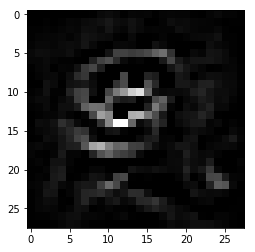

In [23]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
data = MNIST()
print(data.validation_data[0].shape)
# print(mnist_model.predict(data.validation_data[0]))

img = image.load_img("3_hack.png", color_mode = "grayscale", target_size=((28, 28)))
original_image = image.img_to_array(img)
print(original_image.shape)

og = np.expand_dims(original_image, axis=0)

print(mnist_model.predict(og))
print(data.validation_labels[0])

plot_img = original_image.reshape((28,28))
plot_img /= 255.
print(plot_img.shape)
plt.imshow(plot_img, cmap = 'gray')
print("Original Image\n")
plt.show()


In [15]:
mnist_model_distillation = train_distillation(MNIST(), "models/mnist-distilled-100", [32, 32, 64, 64, 200, 200],
                   num_epochs=20, train_temp=100)

(55000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 4s 71us/step - loss: 0.4404 - acc: 0.9282 - val_loss: 0.1016 - val_acc: 0.9702
Epoch 2/20
55000/55000 [==============================] - 3s 59us/step - loss: 0.1357 - acc: 0.9583 - val_loss: 0.0803 - val_acc: 0.9764
Epoch 3/20
55000/55000 [==============================] - 3s 61us/step - loss: 0.1082 - acc: 0.9667 - val_loss: 0.0694 - val_acc: 0.9802
Epoch 4/20
55000/55000 [==============================] - 3s 64us/step - loss: 0.0936 - acc: 0.9715 - val_loss: 0.0637 - val_acc: 0.9798
Epoch 5/20
55000/55000 [==============================] - 4s 65us/step - loss: 0.0847 - acc: 0.9743 - val_loss: 0.0558 - val_acc: 0.9838
Epoch 6/20
55000/55000 [==============================] - 3s 63us/step - loss: 0.0754 - acc: 0.9768 - val_loss: 0.0538 - val_acc: 0.9844
Epoch 7/20
55000/55000 [==============================] - 3s 59us/step - loss: 0.0697 - acc: 0.9783 - val_loss: 0.0541 - val_acc:

In [19]:
print(mnist_model_distillation.predict(og))

[[-11368.487    5554.8013  -4420.0356   2939.328    4802.76    -4766.2007
  -13194.854    -745.6022   8549.191    9542.696 ]]


## Hacking Trained CNN for CIFAR

In [22]:
import foolbox
from foolbox.models import TensorFlowModel, KerasModel
from foolbox.attacks import LBFGSAttack
from foolbox.attacks import DeepFoolAttack, BIM, GradientAttack
from foolbox.criteria import TargetClassProbability
import numpy as np
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
#from keras.applications.resnet50 import decode_predictions

#keras.backend.set_learning_phase(0)
#kmodel = ResNet50(weights='imagenet')
#fmodel = KerasModel(model, bounds=(0, 255), preprocessing=preprocessing)

#preprocessing = (np.array([104, 116, 123]), 1)
# print(cifar_model.summary())

# print(data.validation_data[28])
fmodel = KerasModel(cifar_model, bounds=(0, 255), predicts='logits')


image = data.validation_data[28] #Do not put test_img since it has been expanded
print(data.validation_labels[28])
label = 11

# run the attack
attack = LBFGSAttack(model=fmodel, criterion=TargetClassProbability(10, p=.5))
# attack = BIM(model=fmodel, criterion=TargetClassProbability(10, p=.99))
# attack = GradientAttack(model=fmodel, criterion=TargetClassProbability(10, p=.5))

# attack = DeepFoolAttack(model=fmodel, criterion=TargetClassProbability(1, p=.2))

adversarial = attack(image[:, :, :], label) #image[:, :, ::-1] For BGR

# show results
print(np.argmax(fmodel.predictions(adversarial)))
print(foolbox.utils.softmax(fmodel.predictions(adversarial))[2])
adversarial_rgb = adversarial[np.newaxis, :, :, :] #image[:, :, ::-1] For BGR
preds = model.predict(adversarial_rgb)

print("Prediction: ", preds)

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


AssertionError: ignored

In [0]:
train_distillation(CIFAR(), "models/cifar-distilled-100", [64, 64, 128, 128, 256, 256],
                   num_epochs=50, train_temp=100)